In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [7]:
# Interaction type lookup
import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
# print(interaction_dictionary)

In [8]:
events = Events("/Users/mohammed/code/PandoraRecoFile_1.root")

In [9]:
events.event_number

array([   0,    0,    0, ..., 9208, 9208, 9208], dtype=int32)

In [4]:
events.mc_pdg

array([  22,   22, 2212, ...,   22,   22,   22], dtype=int32)

In [6]:
# def plotparticles(event_number):
#     idx = np.where(events.event_number == event_number)[0]
    
#     residuals = np.array([])
    
#     for i in idx:
#         x = events.reco_hits_x_w[i]
#         z = events.reco_hits_w[i]
#         pdg = events.mc_pdg[i]
        
#         if x.size == 0:
#             continue
            
#         else:
#             m, c = np.polyfit(x, z, 1)
        
#         pred = m * x + c
#         resd = np.mean(np.abs(z - pred))
#         residuals = np.append(residuals, resd)

        
# #         plt.scatter(x, z, s=10)
# #         plt.plot(x, pred)
# #         print(f"Particle {i} and Particle type {pdg}: {resd}")
    
#     vx = events.true_neutrino_vtx_x[idx[0]]
#     vz = events.true_neutrino_vtx_w[idx[0]]
# #     plt.scatter(vx, vz, c='red', s=50)
    
#     typ = events.interaction_type[idx[0]]
#     name = interaction_dictionary[typ]
    
# #     plt.title(f'Interaction Type: {name}')
# #     plt.xlabel('Time')
# #     plt.ylabel('W Wire')
    
#     return residuals

In [7]:
# eventNumbers = list(set(events.event_number))
# # print(eventNumbers)

In [ ]:
# r = []
# for i in eventNumbers:
#     r = np.append(r, plotparticles(i))

In [ ]:
# %matplotlib notebook

# plt.hist(r, 21)

In [24]:
view_w = View(events, "w")

In [78]:
def plotparticles(event_number):
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        plt.scatter(x, z, s=0.5)
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    plt.scatter(vx, vz, c='red', s=50)
    
    typ = events.interaction_type[idx[0]]
    name = interaction_dictionary[typ]
    
    plt.title(f'Interaction Type: {name}')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show

In [86]:
# TRYING AGAIN: 26th October 2023

def residuals(event_number):
    idx = np.where(events.event_number == event_number)[0]
    
    residuals = np.array([])
    particleType = np.array([])
    weights = np.array([])
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]
        weights = 1 / adc
        pdg = events.mc_pdg[i]
        
        if x.size == 0:
            continue
            
        else:
            m, c = np.polyfit(x, z, 1, w=weights)
        
        residual = (np.abs(z - (m * x + c))) / (np.sqrt(1 + m**2))
        avg = (np.sum(residual))/(len(residual))
        residuals = np.append(residuals, avg)
        
        particleType = np.append(particleType, pdg)
        
        plt.figure()
        plt.scatter(x, z, s=10)
        plt.plot(x, m*x+c)
#         plt.title(f'Residual: {residuals[i]}')
#         print(f"Particle {i} and Particle type {pdg}: {resd}")
    
#     vx = events.true_neutrino_vtx_x[idx[0]]
#     vz = events.true_neutrino_vtx_w[idx[0]]
#     plt.scatter(vx, vz, c='red', s=50)
    
    typ = events.interaction_type[idx[0]]
    name = interaction_dictionary[typ]
    
#     plt.title(f'Interaction Type: {name}')
#     plt.xlabel('Time')
#     plt.ylabel('W Wire')
    
    return residuals, particleType

In [117]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    particleType = np.array([])
    
    for i in idx:
        pdg = events.mc_pdg[i]
        particleType = np.append(particleType, pdg)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 1000
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
                plt.show()
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    return gradients, intercepts, resis, particleType

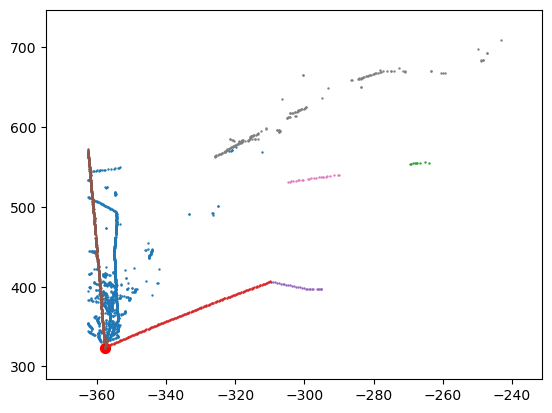

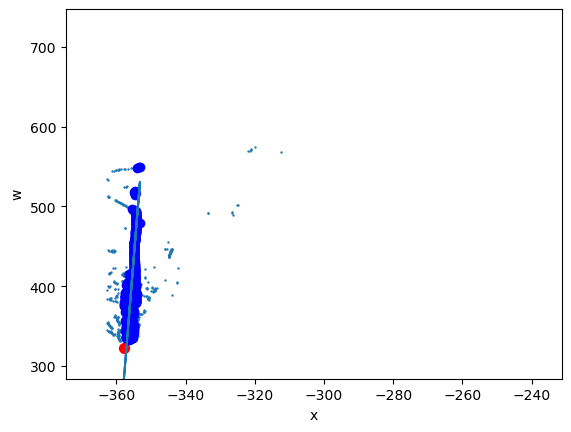

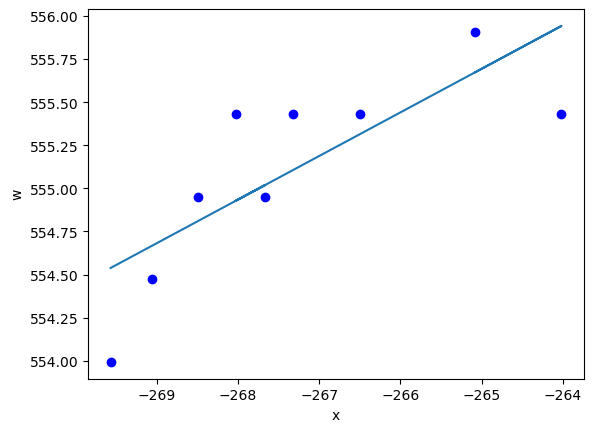

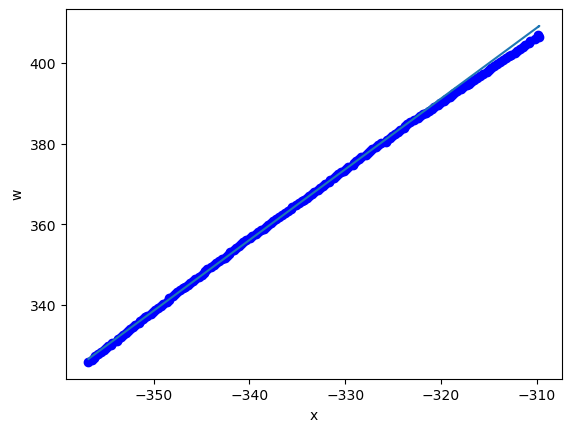

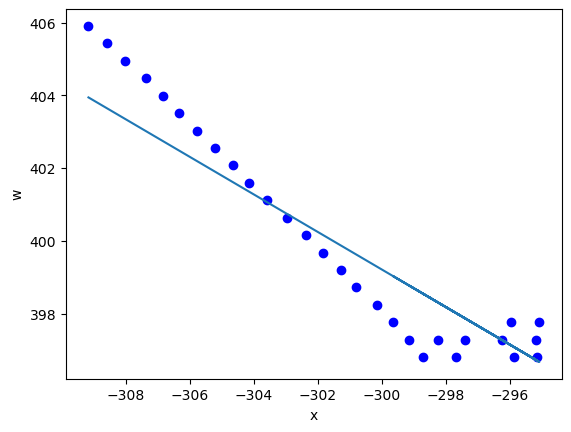

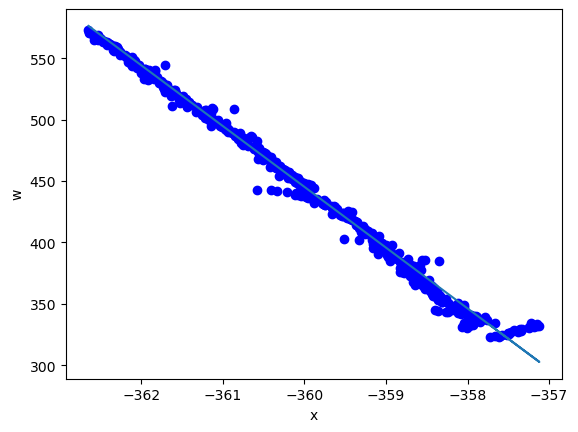

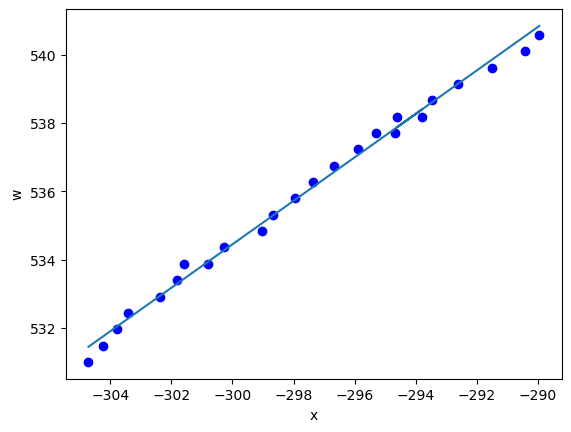

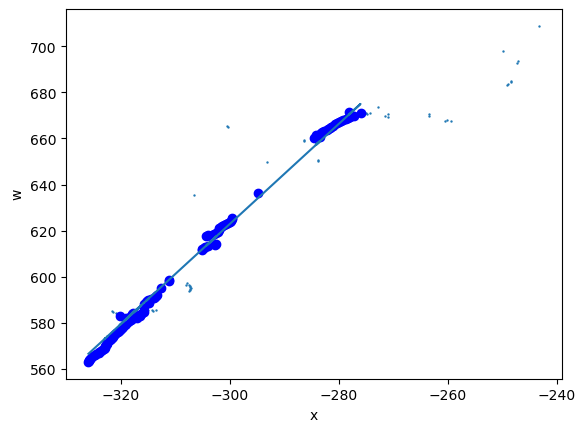

([53.41807,
  0,
  0.2530361,
  1.7525098,
  -0.51612025,
  -49.491463,
  0.637045,
  2.1693916,
  0],
 [19398.129,
  0,
  622.7485,
  951.97485,
  244.37984,
  -17371.697,
  725.5606,
  1273.68,
  0],
 [1.8488984983321386,
  0,
  0.22959550868035816,
  0.15936207869282587,
  0.7574063866479869,
  0.13098844100620569,
  0.1371736483908653,
  1.4584192172543018,
  0])

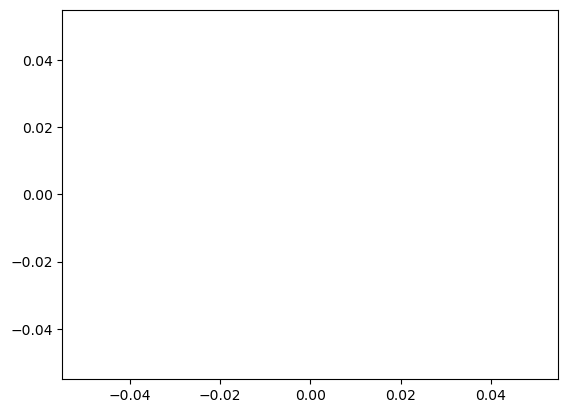

In [107]:
inlierplot(1, True)

In [80]:
# TRYING AGAIN: 26th October 2023

def plotCoords(event_number):
    idx = np.where(events.event_number == event_number)[0]
    gradients = np.array([])
    intercepts = np.array([])
    residuals = np.array([])
    particleType = np.array([])
    weights = np.array([])
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        if x.size == 0:
            gradients = np.append(gradients, 0)
            intercepts = np.append(intercepts, 0)
            residuals = np.append(residuals, 0)
            continue
            
        else:
            m, c = np.polyfit(x, z, 1)
        
        
        gradients = np.append(gradients, m)
        intercepts = np.append(intercepts, c)
        
        residual = (np.abs(z - (m * x + c))) / (np.sqrt(1 + m**2))
        avg = (np.sum(residual))/(len(residual))
        residuals = np.append(residuals, avg)
        
        particleType = np.append(particleType, pdg)
        
        weight = 1.0 / (residual + 1e-6)
        weights = np.append(weights, weight)
        
        weighted_m, weighted_c = np.polyfit(x, z, 1, w=weight)
        
#         plt.figure()
#         plt.scatter(x, z, s=10)
#         plt.plot(x, weighted_m*x+weighted_c)
#         plt.title(f'Residual: {residuals[i]}')
#         print(f"Particle {i} and Particle type {pdg}: {resd}")
    
#     vx = events.true_neutrino_vtx_x[idx[0]]
#     vz = events.true_neutrino_vtx_w[idx[0]]
#     plt.scatter(vx, vz, c='red', s=50)
    
    typ = events.interaction_type[idx[0]]
    name = interaction_dictionary[typ]
    
#     plt.title(f'Interaction Type: {name}')
#     plt.xlabel('Time')
#     plt.ylabel('W Wire')
    
    return gradients, intercepts, residuals

In [81]:
plotCoords(1)

(array([  3.32759224,   0.        ,   0.25303612,   1.71526233,
         -0.65086081, -49.17744188,   0.63072906,   1.824314  ,
          0.        ]),
 array([  1583.34722857,      0.        ,    622.74844564,    939.13522815,
           203.84637996, -17260.30878972,    723.66173693,   1165.50147624,
             0.        ]),
 array([11.38122845,  0.        ,  0.28417516,  0.25190542,  0.58279248,
         0.08932621,  0.15488164,  3.90772288,  0.        ]))

In [113]:
import math
#NEED TO ACCOUNT FOR NO FIT
def coords(event_number):
    m, c, r = inlierplot(event_number, False)
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        #plt.plot(x,z)
    
        if m[i-idx[0]] == 0:
            continue
        else:
            znew = z - c[i-idx[0]]
            angle = -math.atan(m[i-idx[0]])
            l = x * np.cos(angle) - znew * np.sin(angle)
            t = x * np.sin(angle) + znew * np.cos(angle)
#             plt.scatter(l,t)
#             plt.show()

In [114]:
coords(1)

(9,) (9,)


(array([-781.68353, -781.23804, -780.75903, -780.2656 , -779.7318 ,
        -779.13776, -778.56726, -778.0449 , -777.4235 , -776.9238 ,
        -776.40393, -775.82825, -775.2641 , -774.73035, -774.3468 ,
        -773.838  , -773.3202 , -772.84357, -772.41284, -771.9263 ,
        -771.3478 , -770.83124, -770.30914, -769.77515, -769.26074,
        -768.73065, -768.2224 , -767.70166, -767.19135, -766.6797 ,
        -766.1488 , -765.6003 , -765.09106, -764.5499 , -764.0451 ,
        -763.54156, -763.01184, -762.46796, -761.89734, -762.2729 ,
        -761.3775 , -761.80176, -760.96484, -760.56915, -761.3954 ,
        -760.67487, -760.11957, -759.4432 , -761.02576, -759.6236 ,
        -758.9188 , -760.7759 , -759.10547, -758.4062 , -760.4159 ,
        -757.83386, -760.2216 , -759.87646, -756.7411 , -756.35345,
        -756.03723, -756.6939 , -755.6747 , -755.2585 , -754.7785 ,
        -754.23   , -753.99524, -753.7513 , -753.2655 , -752.7431 ,
        -752.1082 , -751.4402 , -750.9288 , -750

In [19]:
%matplotlib inline
plotparticles(1)

(array([11.38122845,  0.28417516,  0.25190542,  0.58279248,  0.08932621,
         0.15488164,  3.90772288]),
 array([  22.,    0.,  211., 2212.,   13.,    0.,    0.]))

In [12]:
eventNumbers = list(set(events.event_number))

In [118]:
r = []
p = []
for i in range(100):
    r = np.append(r, inlierplot(i, False)[2])
    p = np.append(p, inlierplot(i, False)[3])

In [119]:
print(r.shape, p.shape)

(605,) (605,)


In [120]:
print(list(set(p)), len(list(set(p))))

[0.0, 321.0, 2212.0, 1000010020.0, 3112.0, 11.0, 13.0, -211.0, 211.0, -13.0, -11.0, 22.0, -321.0] 13


In [121]:
# protons = 2212
# muons = 13
# electrons = 11

mapping = {11: 'electron', 13: 'muon', 2212: 'proton', -11: 'aelectron', -13: 'amuon', -2212: 'aproton'}
mapping2 = {11: 'shower', 13: 'track', 2212: 'track', -11: 'shower', -13: 'track', -2212: 'track'}

In [122]:
df = pd.DataFrame({"residual": r, "particle": p})
df

,residual,particle
0,0.395808,22.0
1,0.282204,22.0
2,0.487545,2212.0
3,0.230324,13.0
4,0.015838,0.0
...,...,...
600,0.000000,2212.0
601,0.368795,11.0
602,2.780962,22.0
603,12.072176,13.0


In [123]:
df['name'] = df['particle'].map(mapping)
df['type'] = df['particle'].map(mapping2)
df

,residual,particle,name,type
0,0.395808,22.0,NaN,NaN
1,0.282204,22.0,NaN,NaN
2,0.487545,2212.0,proton,track
3,0.230324,13.0,muon,track
4,0.015838,0.0,NaN,NaN
...,...,...,...,...
600,0.000000,2212.0,proton,track
601,0.368795,11.0,electron,shower
602,2.780962,22.0,NaN,NaN
603,12.072176,13.0,muon,track


In [124]:
df = df.dropna()
df

,residual,particle,name,type
2,0.487545,2212.0,proton,track
3,0.230324,13.0,muon,track
5,0.040567,2212.0,proton,track
6,0.014408,2212.0,proton,track
7,0.014827,2212.0,proton,track
...,...,...,...,...
599,0.070029,2212.0,proton,track
600,0.000000,2212.0,proton,track
601,0.368795,11.0,electron,shower
603,12.072176,13.0,muon,track


In [125]:
mapping3 = {'track': 0, 'shower': 1}
# df1 = df
df['class'] = df['type'].map(mapping3)

df

/var/folders/0j/k5n00ph57w3c1tdfq0lwsgn00000gn/T/ipykernel_81410/339389884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['type'].map(mapping3)


,residual,particle,name,type,class
2,0.487545,2212.0,proton,track,0
3,0.230324,13.0,muon,track,0
5,0.040567,2212.0,proton,track,0
6,0.014408,2212.0,proton,track,0
7,0.014827,2212.0,proton,track,0
...,...,...,...,...,...
599,0.070029,2212.0,proton,track,0
600,0.000000,2212.0,proton,track,0
601,0.368795,11.0,electron,shower,1
603,12.072176,13.0,muon,track,0


In [126]:
columns = ['residual', 'class']
df = df[columns]
df

,residual,class
2,0.487545,0
3,0.230324,0
5,0.040567,0
6,0.014408,0
7,0.014827,0
...,...,...
599,0.070029,0
600,0.000000,0
601,0.368795,1
603,12.072176,0


In [127]:
df = df.reset_index(inplace=False, drop=True)
df

,residual,class
0,0.487545,0
1,0.230324,0
2,0.040567,0
3,0.014408,0
4,0.014827,0
...,...,...
312,0.070029,0
313,0.000000,0
314,0.368795,1
315,12.072176,0


In [128]:
# #Normalising the data set

# df['class_frequency'] = df.groupby('class')['class'].transform('count')
# df['normalized_frequency'] = df.groupby('class')['class_frequency'].transform(lambda x: x / x.sum())
# df

In [130]:
# sns.histplot(data=df, x='residual', hue='class', weights='normalized_frequency', element='step', common_norm=False)

<Axes: xlabel='residual', ylabel='Count'>

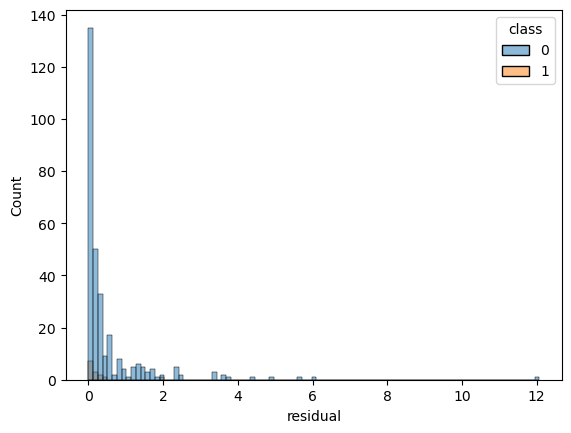

In [131]:
#HISTOGRAM
%matplotlib inline

sns.histplot(data=df, x='residual', hue='class')

In [ ]:
#MACHINE LEARNINGGGGG!!!!!!

In [153]:
X = df['residual']
y = df['class']
print(X.shape, y.shape)

(24698,) (24698,)


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [155]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [156]:
X_train.shape

(17288, 1)

In [157]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [159]:
pred = classifier.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

In [164]:
accuracy = accuracy_score(y_test, pred)
report = classification_report(y_test, pred)

In [165]:
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.6484480431848852
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      5058
           1       0.45      0.44      0.44      2352

    accuracy                           0.65      7410
   macro avg       0.59      0.59      0.59      7410
weighted avg       0.65      0.65      0.65      7410



<IPython.core.display.Javascript object>


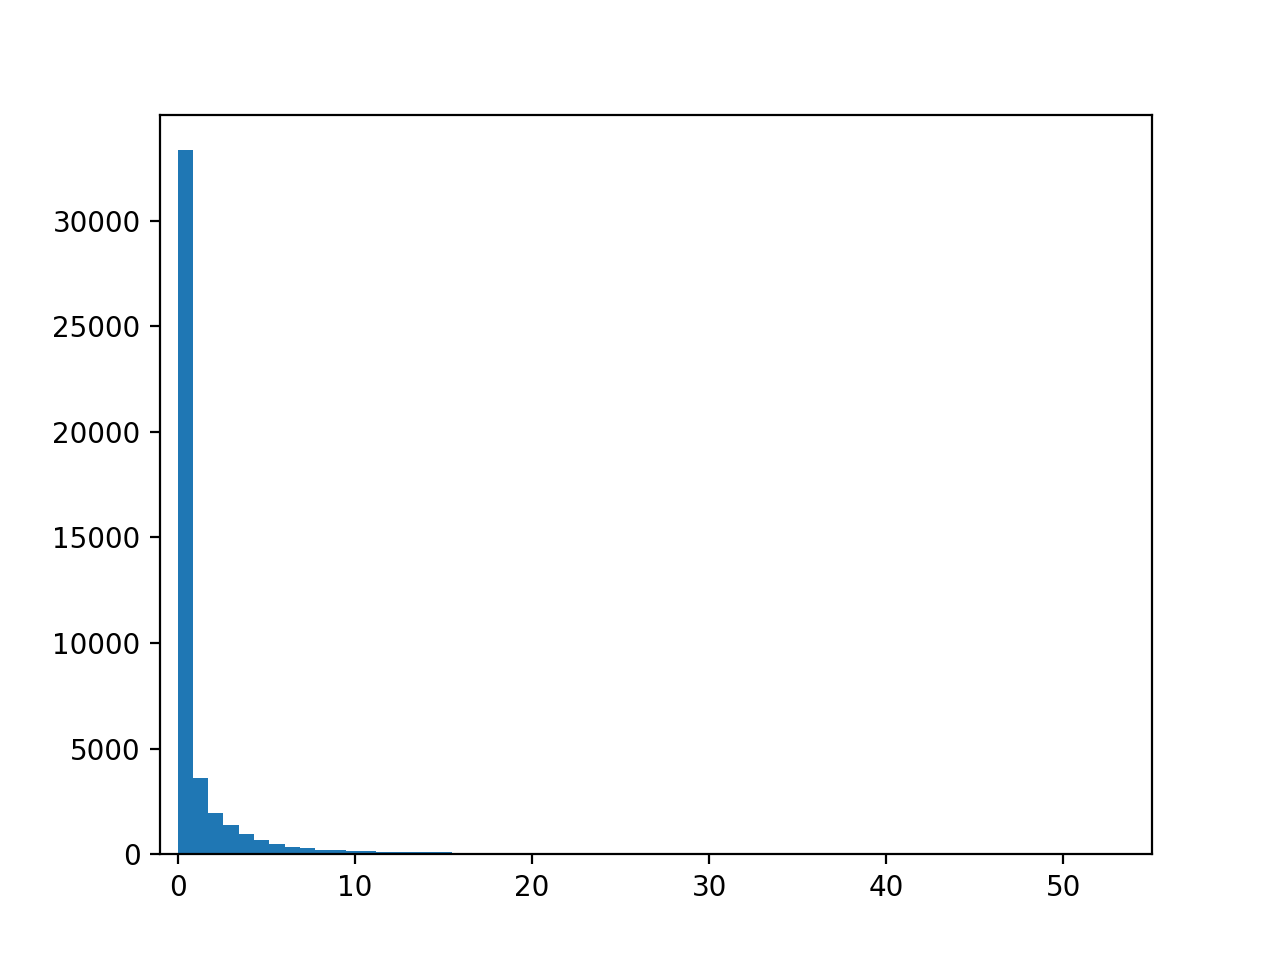

(-1.0, 55.0)

In [16]:
%matplotlib notebook
plt.hist(r, 200)
plt.xlim(-1,55)